# IMDB review classification Elmo embeddings

Elmo explanation

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
# Import our dependencies
import tensorflow as tf
import pandas as pd
import tensorflow_hub as hub
import os
import re
from keras import backend as K
import keras.layers as layers
from keras.models import Model, load_model
from keras.engine import Layer
import numpy as np

# Initialize session
sess = tf.Session()
K.set_session(sess)

Using TensorFlow backend.


## Load Dataset

In [3]:
# Load all files from a directory in a DataFrame.
def load_directory_data(directory):
  data = {}
  data["sentence"] = []
  data["sentiment"] = []
  for file_path in os.listdir(directory):
    with tf.gfile.GFile(os.path.join(directory, file_path), "r") as f:
      data["sentence"].append(f.read())
      data["sentiment"].append(re.match("\d+_(\d+)\.txt", file_path).group(1))
  return pd.DataFrame.from_dict(data)

# Merge positive and negative examples, add a polarity column and shuffle.
def load_dataset(directory):
  pos_df = load_directory_data(os.path.join(directory, "pos"))
  neg_df = load_directory_data(os.path.join(directory, "neg"))
  pos_df["polarity"] = 1
  neg_df["polarity"] = 0
  return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)

# Download and process the dataset files.
def download_and_load_datasets(force_download=False):
  dataset = tf.keras.utils.get_file(
      fname="aclImdb.tar.gz", 
      origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", 
      extract=True)

  train_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                       "aclImdb", "train"))
  test_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                      "aclImdb", "test"))

  return train_df, test_df

# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)

train_df, test_df = download_and_load_datasets()
train_df.head()

84131840/84125825 [==============================] - 2s 0us/step


,sentence,sentiment,polarity
0,"What can I say, this is a piece of brilliant f...",1,0
1,Dark Angel is a cross between Huxley's Brave N...,10,1
2,Watching Midnight Cowboy is like taking a mast...,10,1
3,An MTV-style film crew consisting of American ...,1,0
4,This is a complete Hoax...<br /><br />The movi...,1,0


### Preprocessing the reviews

In [0]:
# Create datasets (Only take up to 150 words for memory)
train_text = train_df['sentence'].tolist()
train_text = [' '.join(t.split()[0:150]) for t in train_text]
train_text = np.array(train_text, dtype=object)[:, np.newaxis]
train_label = train_df['polarity'].tolist()

test_text = test_df['sentence'].tolist()
test_text = [' '.join(t.split()[0:150]) for t in test_text]
test_text = np.array(test_text, dtype=object)[:, np.newaxis]
test_label = test_df['polarity'].tolist()

## Model

### Creating Elmo Layer Class

In [0]:
class ElmoEmbeddingLayer(Layer):
  def __init__(self, **kwargs):
    self.dimensions = 1024
    self.trainable = True
    super(ElmoEmbeddingLayer, self).__init__(**kwargs)
  
  def build(self, input_shape):
    self.elmo = hub.Module('https://tfhub.dev/google/elmo/3', trainable=self.trainable, name="{}_module".format(self.name))
    super(ElmoEmbeddingLayer, self).build(input_shape)

  def call(self, x, mask=None):
    result = self.elmo(K.squeeze(K.cast(x, tf.string), axis=1),
                      as_dict=True,
                      signature='default',
                      )['default']
    return result

  def compute_mask(self, inputs, mask=None):
    return K.not_equal(inputs, '--PAD--')

  def compute_output_shape(self, input_shape):
    return (input_shape[0], self.dimensions)

### Experiment model

In [0]:
def build_model(): 
  input_text = layers.Input(shape=(1,), dtype="string")
  embedding = ElmoEmbeddingLayer()(input_text)
  dense = layers.Dense(256, activation='relu')(embedding)
  pred = layers.Dense(1, activation='sigmoid')(dense)

  model = Model(inputs=[input_text], outputs=pred)

  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  
  return model

In [8]:
# Build and fit
model = build_model()
model.fit(train_text, 
          train_label,
          validation_data=(test_text, test_label),
          epochs=1,
          batch_size=32)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
elmo_embedding_layer_1 (Elmo (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 262,657
Trainable params: 262,657
Non-trainable params: 0
_________________________________________________________________
Train on 25000 samples, validate on 25000 samples
Epoch 1/1
25000/25000 [==============================] - 2514s 101ms/step - loss: 0.4487 - accuracy: 0.7885 - val_loss: 0.4402 - val_accuracy: 0.7944


### Model Creation and Training

In [0]:
def build_model(): 
  input_text = layers.Input(shape=(1,), dtype="string")
  embedding = ElmoEmbeddingLayer()(input_text)
  dense = layers.Dense(64, activation='relu')(embedding)
  pred = layers.Dense(1, activation='sigmoid')(dense)

  model = Model(inputs=[input_text], outputs=pred)

  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  
  return model

In [10]:
# Build and fit
model = build_model()
history = model.fit(train_text, train_label, validation_data=(test_text, test_label),
                   epochs=5, batch_size=128)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
elmo_embedding_layer_2 (Elmo (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                65600     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 65,665
Trainable params: 65,665
Non-trainable params: 0
_________________________________________________________________
Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 1460s 58ms/step - loss: 0.4795 - accuracy: 0.7703 - val_loss: 0.4293 - val_accuracy: 0.8002
Epoch 2/5
25000/25000 [==============================]

### Visualizating results

In [0]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric])
  plt.xlabel('Epochs')
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show() 

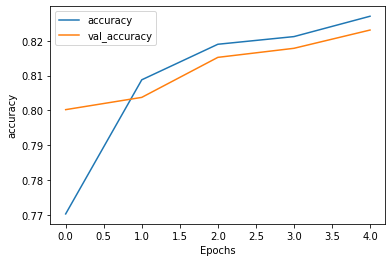

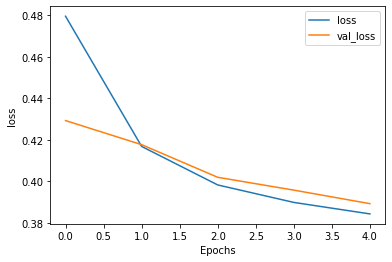

In [12]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')